In [ ]:
#https://colab.research.google.com/drive/1BT_t64JCzr8ge51orG8uLBLIL7w1Hos4
#https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/ch3-xception/xception-architectural-design
#https://maelfabien.github.io/deeplearning/xception/#what-does-it-look-like
#https://machinelearningtokyo.com/2020/04/06/cnn-architectures-xception/
#different Separable convolution network link
#https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
#https://ikhlestov.github.io/pages/machine-learning/convolutions-types/
#https://hackerstreak.com/xception-meet-the-xtreme-inception/
#https://maelfabien.github.io/deeplearning/xception/#the-depthwise-convolution


In [ ]:
import os
import cv2
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import SeparableConv2D, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/Xception')

Mounted at /Xception


In [ ]:
base_dir="/Xception/MyDrive/cats_and_dogs_filtered"
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
train_dir_cats=os.path.join(train_dir,'cats')
train_dir_dogs=os.path.join(train_dir,'dogs')
validation_dir_cats=os.path.join(validation_dir,'cats')
validation_dir_dogs=os.path.join(validation_dir,'dogs')

!find $base_dir -type d -print

/Xception/MyDrive/cats_and_dogs_filtered
/Xception/MyDrive/cats_and_dogs_filtered/validation
/Xception/MyDrive/cats_and_dogs_filtered/validation/cats
/Xception/MyDrive/cats_and_dogs_filtered/validation/dogs
/Xception/MyDrive/cats_and_dogs_filtered/train
/Xception/MyDrive/cats_and_dogs_filtered/train/cats
/Xception/MyDrive/cats_and_dogs_filtered/train/dogs
/Xception/MyDrive/cats_and_dogs_filtered/.ipynb_checkpoints


In [ ]:
num_tr_cats=len(os.listdir(train_dir_cats))
num_tr_dogs=len(os.listdir(train_dir_dogs))
num_val_cats=len(os.listdir(validation_dir_cats))
num_val_dogs=len(os.listdir(validation_dir_dogs))
total_train=(num_tr_cats)+(num_tr_dogs)
total_validation=(num_val_cats)+(num_val_dogs)


In [ ]:
print('total training cat images:', num_tr_cats)
print('total training dog images:', num_tr_dogs)

print('total validation cat images:', num_val_cats)
print('total validation dog images:', num_val_dogs)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_validation)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [ ]:
train_image_generator=ImageDataGenerator(rescale=1/255)
validation_image_generator=ImageDataGenerator(rescale=1/255)

In [ ]:
train_data=train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(299,299)
)

Found 2000 images belonging to 2 classes.


In [ ]:
validation_data=validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(299,299)
)

Found 1000 images belonging to 2 classes.


In [ ]:
################### it require 1 minutes #######################
#all image string converted into images
#that means only after "sample_training_images,_=next(train_data)" we can calculte image shape
sample_training_images,_=next(train_data)
#all image string converted into images
#that means only after "sample_training_images,_=next(validation_data)" we can calculte image shape
sample_validation_images,_=next(validation_data)

In [ ]:
#print: batch size of image,height,width,depth or channel say rgb=3 or grayscale=1
print('shape of train_data      : ',sample_training_images.shape)
print('shape of validation_data : ',sample_validation_images.shape)

shape of train_data      :  (32, 299, 299, 3)
shape of validation_data :  (32, 299, 299, 3)


In [ ]:
def plot_imgage(img_matrix):
  fig,axes=plt.subplots(1,5,figsize=(20,5))
  ##print: batch size of image,height,width,depth or channel say rgb=3 or grayscale=1
  print('shape of images : ',img_matrix.shape)
  for img,ax in zip(img_matrix,axes):
    ax.imshow(img)
    plt.tight_layout()#pic er pasher likha(num 0,50...) valo kore asbe

shape of images :  (5, 299, 299, 3)


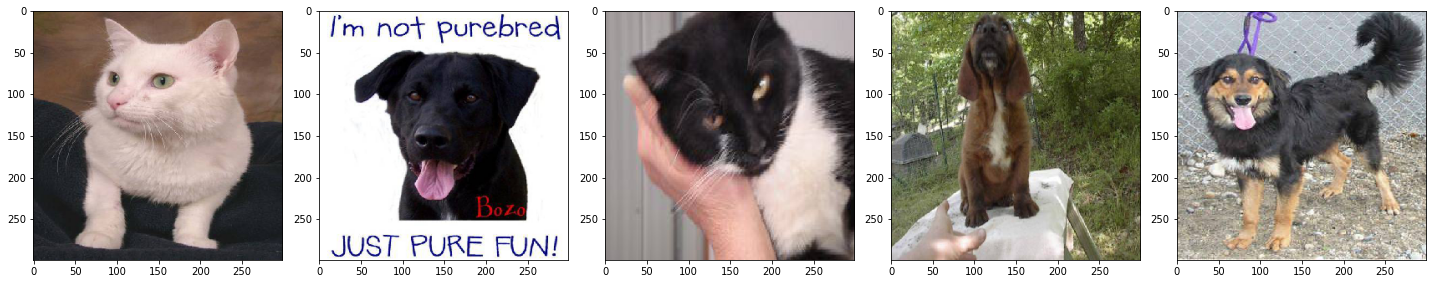

In [ ]:
#pliot images 0 to 4
plot_imgage(sample_training_images[:5])

In [ ]:
def entry_flow(inputs):

  #padding='same' means size of fearure map is same of output feature map
  x=Conv2D(
      filters=32,kernel_size=(3,3),strides=(2,2),padding='same' )(inputs)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(
      filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  previous_block_input=x
  print('entry_flow')
  for size in [128,256,728]:
    
    #the SeparableConv2D is a variation of the traditional convolution that was proposed 
    #to compute it faster. It performs a depthwise spatial convolution followed by a pointwise
    #convolution which mixes together the resulting output channels
    x=Activation('relu')(x)
    x=SeparableConv2D(
        filters=size,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=Activation('relu')(x)
    #https://stackoverflow.com/questions/54705367/what-is-the-difference-between-separableconv2d-and-conv2d-layers
    x=SeparableConv2D(
        filters=size,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    resnet_x=Conv2D(filters=size,kernel_size=(1,1),strides=(2,2),padding='same')(previous_block_input)
    x=Add()([x,resnet_x])
    previous_block_input=x
  return x


In [ ]:
########  call the entry_flow function
input = Input(shape=(299, 299, 3))
model=entry_flow(input)
print(model)

entry_flow
KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 728), dtype=tf.float32, name=None), name='add_2/add:0', description="created by layer 'add_2'")


In [ ]:
def middle_flow(inputs):
  previous_block=inputs
  print('middle_flow')
  for i in range(0,8):
    x=Activation('relu')(previous_block)
    #https://stackoverflow.com/questions/54705367/what-is-the-difference-between-separableconv2d-and-conv2d-layers
    x=SeparableConv2D(filters=728,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=Activation('relu')(x)
    x=SeparableConv2D(filters=728,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=Add()([x,previous_block])
    previous_block=x
    return x


In [ ]:
########  call the middle_flow function
input=Input(shape=(19,19,728))
model=middle_flow(input)
print(model)

KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 728), dtype=tf.float32, name=None), name='add_24/add:0', description="created by layer 'add_24'")


In [ ]:
def exit_flow(inputs):
  print('exit_flow')
  x=Activation('relu')(inputs)
  x=SeparableConv2D(filters=728,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)

  x=Activation('relu')(inputs)
  #https://stackoverflow.com/questions/54705367/what-is-the-difference-between-separableconv2d-and-conv2d-layers
  x=SeparableConv2D(filters=1024,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)

  x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

  resnet_x=Conv2D(filters=1024,kernel_size=(1,1),strides=(2,2),padding='same')(inputs)

  x=Add()([x,resnet_x])

  x=SeparableConv2D(filters=1536,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=SeparableConv2D(filters=2048,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=GlobalAveragePooling2D()(x)
  #Dense er agee output:type_spec=TensorSpec(shape=(None, 2048)
  #################optional fully connected layer ###############
  x=Dense(1,activation='linear')(x)
  #Dense er agee output:type_spec=TensorSpec(shape=(None, 1)
  return x

In [ ]:
########  call the exit_flow function
input=Input(shape=(19,19,728))
model=exit_flow(input)
print(model)

exit_flow
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")


In [ ]:
########## call all the three function at the sme time###############
input=Input(shape=(32,32,3))
output=exit_flow(middle_flow(entry_flow(input)))
print(output)
xception=Model(input,output)

print(xception)

entry_flow
middle_flow
exit_flow
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")


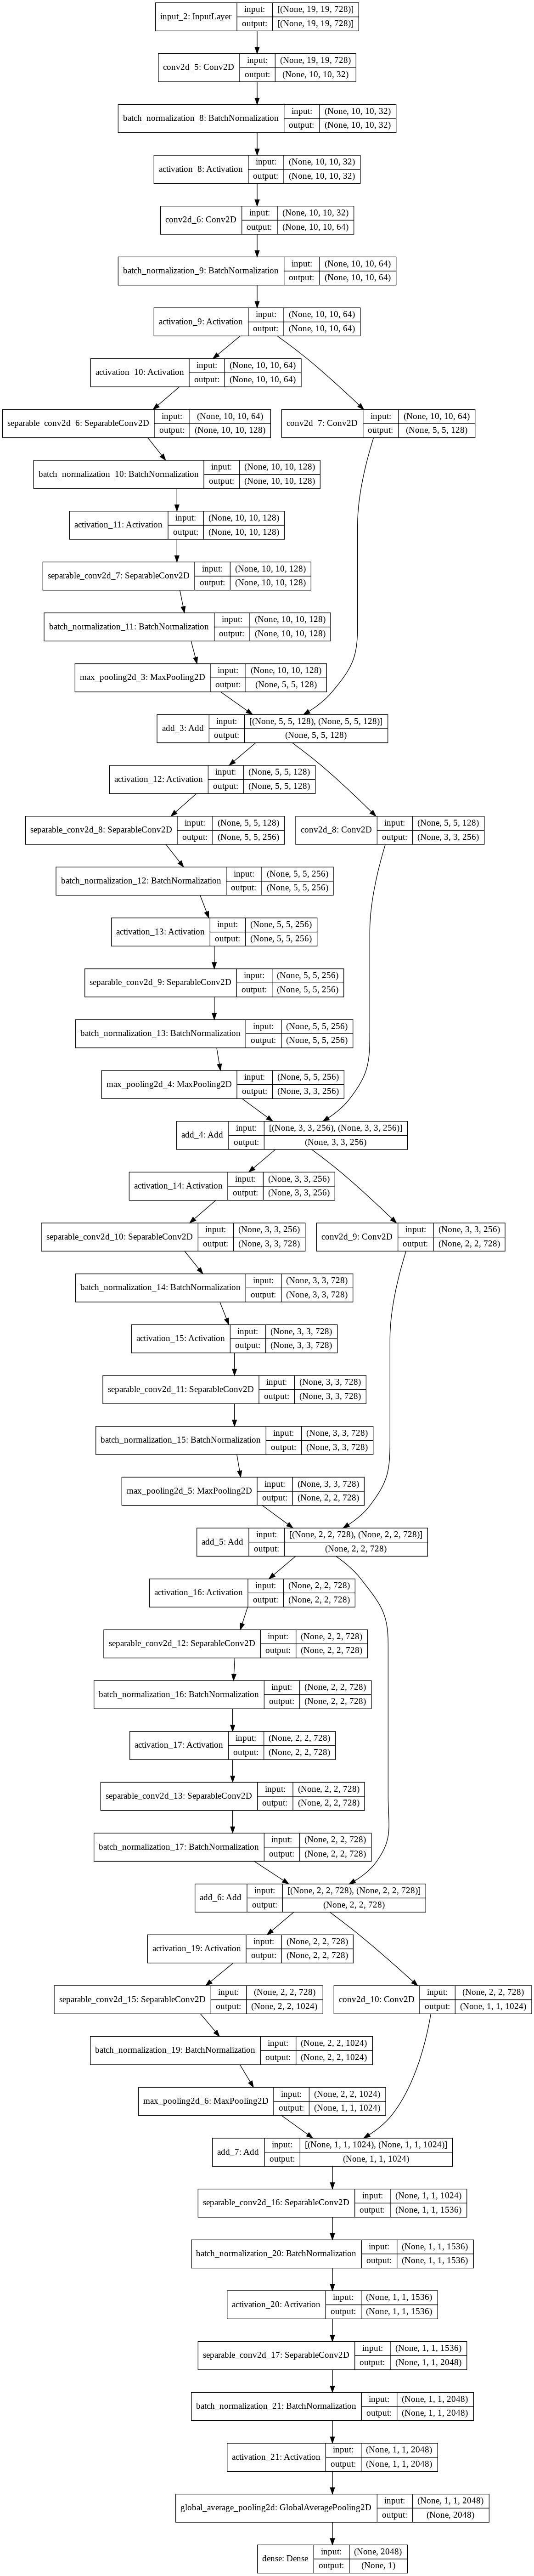

In [ ]:
############ all the function at a image ######################
plot_model(xception, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
xception.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])
xception.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#hist=xception.fit(train_data, validation_data=validation_data, batch_size=128,epochs=3)

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
history = xception.fit(X_train, Y_train, epochs=13, batch_size=64, validation_data=(X_valid, Y_valid))

Epoch 1/13
782/782 [==============================] - 25s 21ms/step - loss: -50.5642 - accuracy: 0.0982 - val_loss: -53.3723 - val_accuracy: 0.1000
Epoch 2/13
782/782 [==============================] - 16s 20ms/step - loss: -53.5853 - accuracy: 0.0977 - val_loss: -53.3723 - val_accuracy: 0.1000
Epoch 3/13
782/782 [==============================] - 16s 20ms/step - loss: -53.1743 - accuracy: 0.0982 - val_loss: -53.3723 - val_accuracy: 0.1000
Epoch 4/13
782/782 [==============================] - 16s 20ms/step - loss: -52.9632 - accuracy: 0.0993 - val_loss: -53.3723 - val_accuracy: 0.1000
Epoch 5/13
782/782 [==============================] - 16s 21ms/step - loss: -53.3284 - accuracy: 0.1013 - val_loss: -53.3723 - val_accuracy: 0.1000
Epoch 6/13
782/782 [==============================] - 16s 21ms/step - loss: -53.4229 - accuracy: 0.0995 - val_loss: -53.3723 - val_accuracy: 0.1000
Epoch 7/13
782/782 [==============================] - 16s 21ms/step - loss: -53.2858 - accuracy: 0.1017 - val_lo

Epoch 1/25
782/782 [==============================] - 35s 40ms/step - loss: 0.0000e+00 - accuracy: 0.1009 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 2/25
782/782 [==============================] - 30s 39ms/step - loss: 0.0000e+00 - accuracy: 0.1016 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 3/25
782/782 [==============================] - 30s 39ms/step - loss: 0.0000e+00 - accuracy: 0.1013 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 4/25
782/782 [==============================] - 30s 39ms/step - loss: 0.0000e+00 - accuracy: 0.1007 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 5/25
782/782 [==============================] - 30s 39ms/step - loss: 0.0000e+00 - accuracy: 0.0998 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 6/25
782/782 [==============================] - 30s 39ms/step - loss: 0.0000e+00 - accuracy: 0.1015 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 7/25
782/782 [==============================] - 30s 39ms/step - loss: 0.0000e+00 -